In [1]:
import torch  # pytorch
import torch.nn as nn  # modul neural network
import torchvision  # library untuk dataset, model
import torchvision.transforms as transforms  # untuk transformasi data
import matplotlib.pyplot as plt  # untuk visualisasi

In [2]:
# Device configuration: Menentukan apakah kita menggunakan GPU ('cuda') atau CPU ('cpu') untuk melatih model.
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Hyperparameters: Parameter-parameter untuk konfigurasi model
input_size = 784  # ukuran input untuk gambar 28x28 (784 pixels)
hidden_size1 = 500  # jumlah neuron di hidden layer pertama
hidden_size2 = 300  # jumlah neuron di hidden layer kedua
num_classes = 10  # jumlah kelas (0-9 untuk dataset MNIST)
num_epochs = 5  # jumlah iterasi penuh untuk seluruh dataset
batch_size = 100  # jumlah sampel per batch
learning_rate = 0.001  # learning rate atau kecepatan pembelajaran untuk optimizer

In [3]:
# MNIST dataset: Mengunduh dan mempersiapkan dataset MNIST
train_dataset = torchvision.datasets.MNIST(root='./data', 
                                           train=True, 
                                           transform=transforms.ToTensor(),  # convert images menjadi tensor
                                           download=True) # download dataset kalau belum ada

test_dataset = torchvision.datasets.MNIST(root='./data', 
                                          train=False, # pakai data testing
                                          transform=transforms.ToTensor())

# DataLoader untuk menggabungkan data menjadi batch
train_loader = torch.utils.data.DataLoader(dataset=train_dataset, 
                                           batch_size=batch_size, 
                                           shuffle=True) # mengacak data untuk setiap epoch

test_loader = torch.utils.data.DataLoader(dataset=test_dataset, 
                                          batch_size=batch_size, 
                                          shuffle=False)  # tidak perlu mengacak data testing

In [4]:
# Definisi arsitektur Neural Network dengan menambah hidden layer kedua
class NeuralNetReLU(nn.Module):
    def __init__(self, input_size, hidden_size1, hidden_size2, num_classes):
        super(NeuralNetReLU, self).__init__()
        # Layer pertama (hidden layer pertama)
        self.fc1 = nn.Linear(input_size, hidden_size1)  
        self.relu1 = nn.ReLU()  # Aktivasi ReLU untuk hidden layer pertama
        
        # Layer kedua (hidden layer kedua)
        self.fc2 = nn.Linear(hidden_size1, hidden_size2)
        self.relu2 = nn.ReLU()  # Aktivasi ReLU untuk hidden layer kedua
        
        # Layer ketiga (output layer)
        self.fc3 = nn.Linear(hidden_size2, num_classes)  
    
    def forward(self, x):
        # Forward pass melalui hidden layer pertama
        out = self.fc1(x)
        out = self.relu1(out)
        
        # Forward pass melalui hidden layer kedua
        out = self.fc2(out)
        out = self.relu2(out)
        
        # Forward pass ke output layer
        out = self.fc3(out)
        return out

# Definisi model dengan aktivasi Sigmoid
class NeuralNetSigmoid(nn.Module):
    def __init__(self, input_size, hidden_size1, hidden_size2, num_classes):
        super(NeuralNetSigmoid, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size1)
        self.fc2 = nn.Linear(hidden_size1, hidden_size2)
        self.fc3 = nn.Linear(hidden_size2, num_classes)
    
    def forward(self, x):
        # Aktivasi Sigmoid untuk hidden layers
        out = torch.sigmoid(self.fc1(x))
        out = torch.sigmoid(self.fc2(out))
        out = self.fc3(out)
        return out

# Definisi model dengan aktivasi Tanh
class NeuralNetTanh(nn.Module):
    def __init__(self, input_size, hidden_size1, hidden_size2, num_classes):
        super(NeuralNetTanh, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size1)
        self.fc2 = nn.Linear(hidden_size1, hidden_size2)
        self.fc3 = nn.Linear(hidden_size2, num_classes)
    
    def forward(self, x):
        # Aktivasi Tanh untuk hidden layers
        out = torch.tanh(self.fc1(x))
        out = torch.tanh(self.fc2(out))
        out = self.fc3(out)
        return out

In [5]:
# Inisialisasi model dengan tiga aktivasi yang berbeda
model_relu = NeuralNetReLU(input_size, hidden_size1, hidden_size2, num_classes).to(device)
model_sigmoid = NeuralNetSigmoid(input_size, hidden_size1, hidden_size2, num_classes).to(device)
model_tanh = NeuralNetTanh(input_size, hidden_size1, hidden_size2, num_classes).to(device)

In [6]:
# Definisi loss function dan optimizer
criterion = nn.CrossEntropyLoss()  # Loss function untuk klasifikasi multi-kelas
optimizer_relu = torch.optim.Adam(model_relu.parameters(), lr=learning_rate)  # Optimizer untuk model ReLU
optimizer_sigmoid = torch.optim.Adam(model_sigmoid.parameters(), lr=learning_rate)  # Optimizer untuk model Sigmoid
optimizer_tanh = torch.optim.Adam(model_tanh.parameters(), lr=learning_rate)  # Optimizer untuk model Tanh

In [7]:
# Fungsi untuk melatih model
def train_model(model, train_loader, num_epochs, criterion, optimizer):
    loss_values = []  # List untuk menyimpan nilai loss untuk visualisasi
    total_step = len(train_loader)  # Total langkah per epoch
    for epoch in range(num_epochs):
        for i, (images, labels) in enumerate(train_loader):  
            images = images.reshape(-1, 28*28).to(device)  # Mengubah ukuran gambar menjadi vektor 784
            labels = labels.to(device)
            
            # Forward pass
            outputs = model(images)
            loss = criterion(outputs, labels)  # Menghitung loss
            
            # Backward and optimize: Langkah untuk mengoptimalkan bobot
            optimizer.zero_grad()  # Mengosongkan gradien dari iterasi sebelumnya
            loss.backward()  # Backward pass: Menghitung gradien
            optimizer.step()  # Memperbarui parameter menggunakan optimizer
            
            loss_values.append(loss.item())  # Menyimpan nilai loss untuk visualisasi
            
            if (i+1) % 100 == 0:  # Menampilkan informasi setiap 100 langkah
                print ('Epoch [{}/{}], Step [{}/{}], Loss: {:.4f}' 
                       .format(epoch+1, num_epochs, i+1, total_step, loss.item()))
    return loss_values

In [8]:
# Fungsi untuk menguji model
def test_model(model, test_loader):
    with torch.no_grad():
        correct = 0
        total = 0
        for images, labels in test_loader:
            images = images.reshape(-1, 28*28).to(device)
            labels = labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    accuracy = 100 * correct / total
    print('Accuracy of the network on the 10000 test images: {} %'.format(accuracy))
    return accuracy

In [9]:
# Fungsi untuk mem-plot loss
def plot_loss(loss_values, title):
    plt.figure(figsize=(10, 5))
    plt.plot(loss_values, label='Loss during Training')
    plt.xlabel('Iteration')
    plt.ylabel('Loss')
    plt.title(title)
    plt.legend()
    plt.show()

Training Model with ReLU Activation
Epoch [1/5], Step [100/600], Loss: 0.3588
Epoch [1/5], Step [200/600], Loss: 0.3712
Epoch [1/5], Step [300/600], Loss: 0.0749
Epoch [1/5], Step [400/600], Loss: 0.0919
Epoch [1/5], Step [500/600], Loss: 0.0595
Epoch [1/5], Step [600/600], Loss: 0.1042
Epoch [2/5], Step [100/600], Loss: 0.0594
Epoch [2/5], Step [200/600], Loss: 0.1140
Epoch [2/5], Step [300/600], Loss: 0.0928
Epoch [2/5], Step [400/600], Loss: 0.0655
Epoch [2/5], Step [500/600], Loss: 0.1001
Epoch [2/5], Step [600/600], Loss: 0.0427
Epoch [3/5], Step [100/600], Loss: 0.0681
Epoch [3/5], Step [200/600], Loss: 0.0112
Epoch [3/5], Step [300/600], Loss: 0.1024
Epoch [3/5], Step [400/600], Loss: 0.0326
Epoch [3/5], Step [500/600], Loss: 0.1470
Epoch [3/5], Step [600/600], Loss: 0.0744
Epoch [4/5], Step [100/600], Loss: 0.0185
Epoch [4/5], Step [200/600], Loss: 0.0257
Epoch [4/5], Step [300/600], Loss: 0.0298
Epoch [4/5], Step [400/600], Loss: 0.0218
Epoch [4/5], Step [500/600], Loss: 0.023

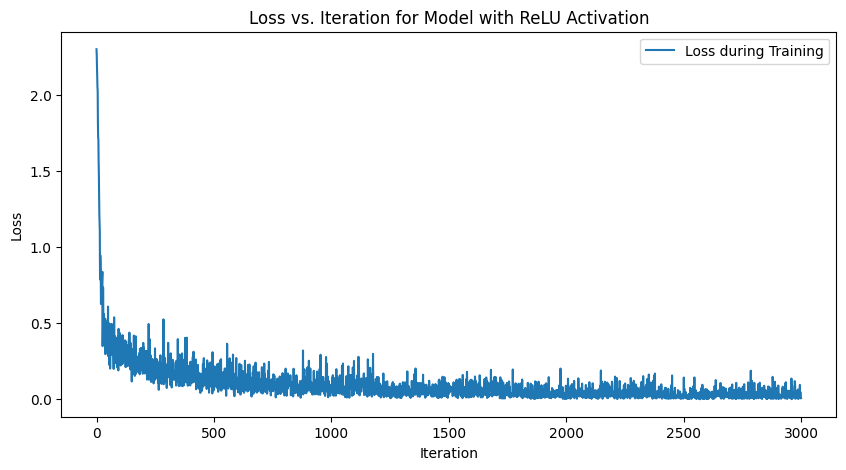

Accuracy of the network on the 10000 test images: 97.79 %


97.79

In [10]:
# Train dan visualisasi untuk model dengan ReLU
print("Training Model with ReLU Activation")
loss_values_relu = train_model(model_relu, train_loader, num_epochs, criterion, optimizer_relu)
plot_loss(loss_values_relu, 'Loss vs. Iteration for Model with ReLU Activation')
test_model(model_relu, test_loader)


Training Model with Sigmoid Activation
Epoch [1/5], Step [100/600], Loss: 0.6638
Epoch [1/5], Step [200/600], Loss: 0.2747
Epoch [1/5], Step [300/600], Loss: 0.3786
Epoch [1/5], Step [400/600], Loss: 0.3107
Epoch [1/5], Step [500/600], Loss: 0.2310
Epoch [1/5], Step [600/600], Loss: 0.2387
Epoch [2/5], Step [100/600], Loss: 0.1770
Epoch [2/5], Step [200/600], Loss: 0.1994
Epoch [2/5], Step [300/600], Loss: 0.2523
Epoch [2/5], Step [400/600], Loss: 0.1399
Epoch [2/5], Step [500/600], Loss: 0.1125
Epoch [2/5], Step [600/600], Loss: 0.2289
Epoch [3/5], Step [100/600], Loss: 0.2045
Epoch [3/5], Step [200/600], Loss: 0.0965
Epoch [3/5], Step [300/600], Loss: 0.1074
Epoch [3/5], Step [400/600], Loss: 0.1276
Epoch [3/5], Step [500/600], Loss: 0.0621
Epoch [3/5], Step [600/600], Loss: 0.0566
Epoch [4/5], Step [100/600], Loss: 0.0555
Epoch [4/5], Step [200/600], Loss: 0.1173
Epoch [4/5], Step [300/600], Loss: 0.1095
Epoch [4/5], Step [400/600], Loss: 0.0721
Epoch [4/5], Step [500/600], Loss: 0

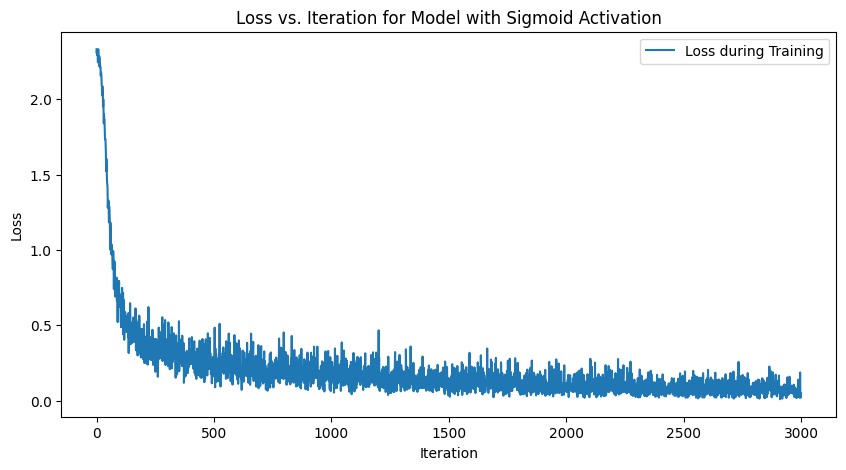

Accuracy of the network on the 10000 test images: 97.04 %


97.04

In [11]:
# Train dan visualisasi untuk model dengan Sigmoid
print("\nTraining Model with Sigmoid Activation")
loss_values_sigmoid = train_model(model_sigmoid, train_loader, num_epochs, criterion, optimizer_sigmoid)
plot_loss(loss_values_sigmoid, 'Loss vs. Iteration for Model with Sigmoid Activation')
test_model(model_sigmoid, test_loader)


Training Model with Tanh Activation
Epoch [1/5], Step [100/600], Loss: 0.3868
Epoch [1/5], Step [200/600], Loss: 0.2205
Epoch [1/5], Step [300/600], Loss: 0.3201
Epoch [1/5], Step [400/600], Loss: 0.2048
Epoch [1/5], Step [500/600], Loss: 0.2624
Epoch [1/5], Step [600/600], Loss: 0.1659
Epoch [2/5], Step [100/600], Loss: 0.1091
Epoch [2/5], Step [200/600], Loss: 0.1696
Epoch [2/5], Step [300/600], Loss: 0.1571
Epoch [2/5], Step [400/600], Loss: 0.0998
Epoch [2/5], Step [500/600], Loss: 0.0787
Epoch [2/5], Step [600/600], Loss: 0.0702
Epoch [3/5], Step [100/600], Loss: 0.1012
Epoch [3/5], Step [200/600], Loss: 0.0408
Epoch [3/5], Step [300/600], Loss: 0.0544
Epoch [3/5], Step [400/600], Loss: 0.0468
Epoch [3/5], Step [500/600], Loss: 0.1510
Epoch [3/5], Step [600/600], Loss: 0.0579
Epoch [4/5], Step [100/600], Loss: 0.0586
Epoch [4/5], Step [200/600], Loss: 0.0454
Epoch [4/5], Step [300/600], Loss: 0.0393
Epoch [4/5], Step [400/600], Loss: 0.1295
Epoch [4/5], Step [500/600], Loss: 0.07

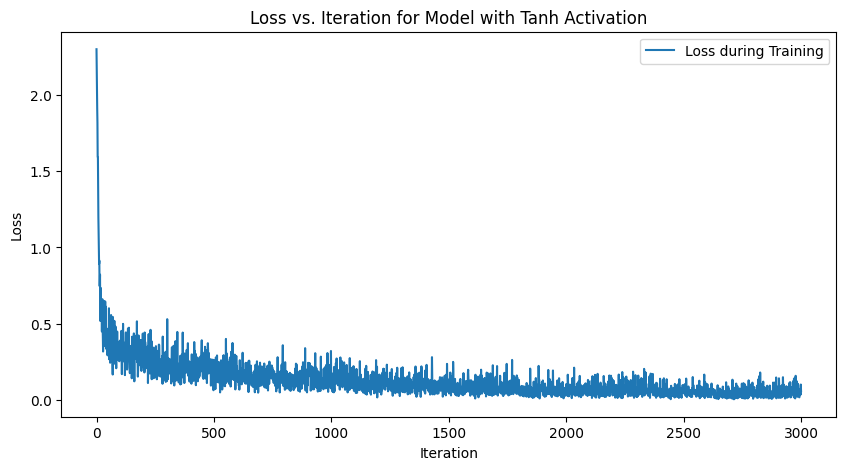

Accuracy of the network on the 10000 test images: 97.45 %


97.45

In [12]:
# Train dan visualisasi untuk model dengan Tanh
print("\nTraining Model with Tanh Activation")
loss_values_tanh = train_model(model_tanh, train_loader, num_epochs, criterion, optimizer_tanh)
plot_loss(loss_values_tanh, 'Loss vs. Iteration for Model with Tanh Activation')
test_model(model_tanh, test_loader)